In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew
#from scipy.special import boxcox1px
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
import scipy.special as ss

In [3]:
%matplotlib inline

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
train = train[(train.GrLivArea < 4500)]
train.reset_index(drop=True, inplace=True)
# train["SalePrice"] = np.log1p(train["SalePrice"])
y = train['SalePrice'].reset_index(drop=True).copy()

In [6]:
test_ID = test.Id

In [7]:
train.drop('Id',inplace=True, axis=1)
test.drop('Id',inplace=True, axis=1)

In [8]:
print(train.shape, test.shape)

(1458, 80) (1459, 79)


In [9]:
data = pd.concat((train,test)).reset_index(drop=True)
print(data.shape)

(2917, 80)


In [10]:
data_nans = data.isnull().sum()
data_nans = data_nans[data_nans > 0]
data_nans.sort_values(ascending=False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64

In [11]:
strings = ['MSSubClass']
for var in strings:
    data[var] = data[var].apply(str)

In [12]:
groups = ['Exterior1st','Exterior2nd','SaleType','Electrical','KitchenQual']
for group in groups:
    mode = data[group].mode()[0]
    data[group] = data[group].fillna(mode)

    
data.MSZoning = data.MSZoning.fillna('RL')

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual',
            'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"PoolQC"
           ,'Alley','Fence','MiscFeature','FireplaceQu','MasVnrType','Utilities']:
    data[col] = data[col].fillna('None')
    
for col in ('GarageArea', 'GarageCars','MasVnrArea','BsmtFinSF1','BsmtFinSF2'
           ,'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BsmtUnfSF','TotalBsmtSF', 'GarageYrBlt'):
    data[col] = data[col].fillna(0)
    

data.Functional = data.Functional.fillna('Typ')

data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [13]:
data_nans = data.isnull().sum()
data_nans = data_nans[data_nans > 0]
data_nans.sort_values(ascending=False)

SalePrice    1459
dtype: int64

In [14]:
data.drop(['SalePrice'], axis=1, inplace=True)

In [15]:
cat_features = data.select_dtypes(include=['object']).columns
print(cat_features)
num_features = data.select_dtypes(exclude=['object']).columns
print(num_features)

Index(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig',
       'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature',
       'Neighborhood', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle',
       'SaleCondition', 'SaleType', 'Street', 'Utilities'],
      dtype='object')
Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea',
       'LotFrontage', 'LowQua

### Skewing

In [16]:
# feat_num = data[num_features].drop(['GarageYrBlt','MoSold','OverallCond',
#                                     'OverallQual','TotRmsAbvGrd','YearBuilt',
#                                     'YearRemodAdd','YrSold','BsmtFullBath','BsmtHalfBath',
#                                    'FullBath','HalfBath','KitchenAbvGr','Fireplaces','GarageCars'],axis=1)
# feat_cat = data[cat_features]

In [17]:
# skewness = feat_num.apply(lambda x: skew(x))
# skewness.sort_values(ascending=False)

In [18]:
# skewness = skewness[abs(skewness) > 0.5]
# skewed_features = skewness.index
# for feat in skewed_features:
#     feat_num[feat] = ss.boxcox1p(feat_num[feat], boxcox_normmax(feat_num[feat] + 1))

In [19]:
# skewness = feat_num.apply(lambda x: skew(x))
# skewness = skewness[abs(skewness) > 0.5]

# print("There are {} skewed numerical features after Box Cox transform".format(skewness.shape[0]))
# print("Mean skewnees: {}".format(np.mean(skewness)))
# skewness.sort_values(ascending=False)

In [20]:
# for col in feat_num.columns:
#     data[col] = feat_num[col]

In [21]:
data['TotalSF'] = data.TotalBsmtSF + data['1stFlrSF'] + data['2ndFlrSF']
data['TotalBath'] = data.FullBath + 0.5 * data.HalfBath + data.BsmtFullBath + 0.5 * data.BsmtHalfBath
data['TotalPorch'] = data.OpenPorchSF + data['3SsnPorch'] + data.EnclosedPorch + data.ScreenPorch + data.WoodDeckSF

data['YrBltAndRemod']=data.YearBuilt + data.YearRemodAdd


data['TotYear'] = data.YearBuilt + data.YearRemodAdd + data.YrSold
data['HasPool'] = data.PoolArea.apply(lambda x: 1 if x > 0 else 0)
data['HasGarage'] = data.GarageArea.apply(lambda x: 1 if x > 0 else 0)
data['HasBsmt'] = data.TotalBsmtSF.apply(lambda x: 1 if x > 0 else 0)
data['HasFirePl'] = data.Fireplaces.apply(lambda x: 1 if x > 0 else 0)
data['BeforeCrisis'] = data.YrSold.apply(lambda x: 1 if x < 2009 else 0)

data.shape

(2917, 89)

In [22]:
qual_dict = {"None": 0, "Po": 1, "Fa": 2, "TA": 4, "Gd": 7, "Ex": 11}
qual_cols = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", 
             "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"]

for cat in data.columns:
    if cat in qual_cols:
        data[cat] = data[cat].map(qual_dict).astype('int64')

In [23]:
drops = ['Utilities', 'Street', 'PoolQC', 'MiscFeature', 'Alley', 'Fence']
data = data.drop(drops,axis=1)

In [24]:
cat_features = data.select_dtypes(include=['object']).columns
print(cat_features)
num_features = data.select_dtypes(exclude=['object']).columns
print(num_features)

Index(['BldgType', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'Exterior1st',
       'Exterior2nd', 'Foundation', 'Functional', 'GarageFinish', 'GarageType',
       'Heating', 'HouseStyle', 'LandContour', 'LandSlope', 'LotConfig',
       'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'Neighborhood',
       'PavedDrive', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType'],
      dtype='object')
Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtCond',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual',
       'BsmtUnfSF', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'FireplaceQu',
       'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageQual', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'HeatingQC',
       'KitchenAbvGr', 'KitchenQual', 'LotArea', 'LotFrontage', 'LowQualFinSF',
       'MasVnrArea', 'MiscVal', 'MoSold', 'OpenPorchSF', 'OverallCond',

In [25]:
feat_num = data[num_features]
feat_cat = data[cat_features]

In [26]:
feat_num = feat_num.apply(lambda x: (x - np.mean(x)) / np.std(x)).reset_index(drop=True)

In [27]:
feat_num.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtQual,...,TotalSF,TotalBath,TotalPorch,YrBltAndRemod,TotYear,HasPool,HasGarage,HasBsmt,HasFirePl,BeforeCrisis
0,-0.783214,1.210473,-0.103366,0.169987,0.064058,0.601514,-0.293134,1.090257,-0.249810,0.547756,...,0.030064,1.590503,-0.761881,1.094096,1.097916,-0.064271,0.239306,0.166843,-1.026755,0.714574
1,0.270789,-0.784638,-0.103366,0.169987,0.064058,1.213983,-0.293134,-0.818675,3.821109,0.547756,...,-0.023717,0.350990,0.721802,-0.076667,-0.093801,-0.064271,0.239306,0.166843,0.973942,0.714574
2,-0.617065,1.238507,-0.103366,0.169987,0.064058,0.106135,-0.293134,1.090257,-0.249810,0.547756,...,0.209336,1.590503,-0.880826,1.029054,1.032913,-0.064271,0.239306,0.166843,0.973942,0.714574
3,-0.510627,0.981526,-0.103366,0.169987,3.094194,-0.501830,-0.293134,1.090257,-0.249810,-0.703135,...,-0.089023,-0.268767,0.778145,-1.529280,-1.567197,-0.064271,0.239306,0.166843,0.973942,0.714574
4,-0.032951,1.675376,-0.103366,1.385311,0.064058,0.486676,-0.293134,1.090257,-0.249810,0.547756,...,1.025022,1.590503,0.584076,0.964011,0.967910,-0.064271,0.239306,0.166843,0.973942,0.714574


In [28]:
cat_data = pd.get_dummies(feat_cat).reset_index(drop=True)

In [29]:
fin_data = pd.concat([feat_num,cat_data],axis=1).reset_index(drop=True)

In [30]:
fin_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtQual,...,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,-0.783214,1.210473,-0.103366,0.169987,0.064058,0.601514,-0.293134,1.090257,-0.249810,0.547756,...,0,0,0,0,0,0,0,0,0,1
1,0.270789,-0.784638,-0.103366,0.169987,0.064058,1.213983,-0.293134,-0.818675,3.821109,0.547756,...,0,0,0,0,0,0,0,0,0,1
2,-0.617065,1.238507,-0.103366,0.169987,0.064058,0.106135,-0.293134,1.090257,-0.249810,0.547756,...,0,0,0,0,0,0,0,0,0,1
3,-0.510627,0.981526,-0.103366,0.169987,3.094194,-0.501830,-0.293134,1.090257,-0.249810,-0.703135,...,0,0,0,0,0,0,0,0,0,1
4,-0.032951,1.675376,-0.103366,1.385311,0.064058,0.486676,-0.293134,1.090257,-0.249810,0.547756,...,0,0,0,0,0,0,0,0,0,1


In [31]:
print(fin_data.shape)
train = fin_data.iloc[:len(y),:]
test = fin_data.iloc[len(y):,:]
print(train.shape,y.shape,test.shape)

(2917, 268)
(1458, 268) (1458,) (1459, 268)


In [32]:
outliers = [30, 88, 462, 631, 1322]
train = train.drop(train.index[outliers])
y_train = y.drop(y.index[outliers])

In [33]:
print(train.shape,y_train.shape,test.shape)

(1453, 268) (1453,) (1459, 268)


In [34]:
train['SalePrice'] = y_train

In [35]:
print(train.shape)

(1453, 269)


In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [37]:
train_set = train.sample(frac=0.8, random_state=0)
test_set = train.drop(train_set.index)

In [38]:
train_labels = train_set.pop('SalePrice')
test_labels = test_set.pop('SalePrice')

In [39]:
train_stats = train_set.describe()
train_stats = train_stats.transpose()
train_stats.head()

,count,mean,std,min,25%,50%,75%,max
1stFlrSF,1162.0,-0.021105,0.961047,-2.138360,-0.736484,-0.201695,0.571284,5.374654
2ndFlrSF,1162.0,0.051499,1.025679,-0.784638,-0.784638,-0.784638,0.941811,4.039606
3SsnPorch,1162.0,0.023062,1.078181,-0.103366,-0.103366,-0.103366,-0.103366,16.052303
BedroomAbvGr,1162.0,0.018333,1.010668,-3.475984,-1.045337,0.169987,0.169987,6.246606
BsmtCond,1162.0,0.043197,0.999773,-3.976123,0.064058,0.064058,0.064058,3.094194


In [40]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_set.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In [41]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                17216     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 21,441
Trainable params: 21,441
Non-trainable params: 0
_________________________________________________________________


In [43]:
normed_train_data = train_set
normed_test_data = test_set

In [44]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.5491716 ],
       [ 0.22740135],
       [-0.05960862],
       [-0.15165256],
       [-0.56253356],
       [ 0.08162457],
       [ 0.06984158],
       [-0.49638602],
       [ 0.07263932],
       [-0.5375338 ]], dtype=float32)

In [45]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print('')
            print(epoch)
        print('.', end='')


In [46]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [log(SalePrice)]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],label = 'Val Error')
    plt.ylim([5_000,20_000])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$log(SalePrice)$]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],label = 'Val Error')
    plt.ylim([5_000,20_000])
    plt.legend()
    plt.show()

In [56]:
model = build_model()

EPOCHS = 5000

# Параметр patience определяет количество эпох, проверяемых на улучшение
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])




0
....................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................

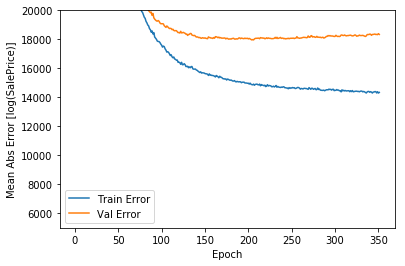

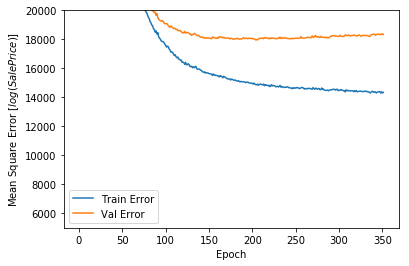

In [57]:
plot_history(history)

In [58]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))


 - 0s - loss: 438778505.2921 - mean_absolute_error: 15484.2461 - mean_squared_error: 438778496.0000
Testing set Mean Abs Error: 15484.25


In [59]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
347,4.206044e+08,14391.632812,420604416.0,8.539346e+08,18332.935547,853934592.0,347
348,4.200126e+08,14300.065430,420012704.0,8.532402e+08,18342.722656,853240192.0,348
349,4.200891e+08,14389.841797,420089120.0,8.558498e+08,18326.224609,855849792.0,349
350,4.182515e+08,14296.264648,418251488.0,8.524665e+08,18391.677734,852466560.0,350
351,4.186706e+08,14339.546875,418670592.0,8.533907e+08,18339.384766,853390656.0,351


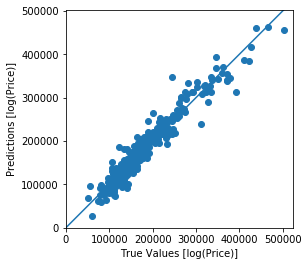

In [60]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [log(Price)]')
plt.ylabel('Predictions [log(Price)]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,plt.xlim()[1]])
plt.ylim([10,plt.ylim()[1]])
_ = plt.plot([-1000_000, 1000_000], [-1000_000, 1000_000])


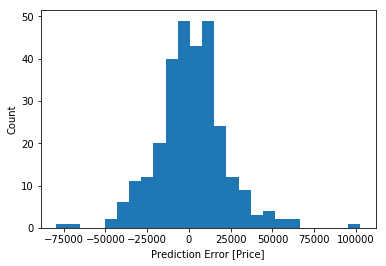

In [61]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Price]")
_ = plt.ylabel("Count")


In [62]:
result = model.predict(test)

In [63]:
result

array([[112526.586],
       [179962.6  ],
       [176530.42 ],
       ...,
       [180631.97 ],
       [117412.84 ],
       [211714.5  ]], dtype=float32)

In [64]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = result
sub.to_csv('2020-02-12 sub NN no log no features.csv',index=False)